In [ ]:
!pip install pandas
!pip install scikit-learn
!pip install sdv
!pip install imbalanced-learn
!pip install matplotlib
!pip install numpy

#### `Key Imports`



In [3]:
from dataset.data_preprocessing import *
from Preprocessing_Functions2 import *
from Training_Helper_Functions import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



Using cpu


#### `Dataset Augmentation Functions`

In [14]:

def CV_generator(training:pd.DataFrame, validation:pd.DataFrame, OD_majority=None, OD_minority=None, synthesizer = "TVAE", epochs = 1000, n_synthetic_data=10000, scaler=StandardScaler()):
    cont_cols = ['Age', 'UAlb', 'Ucr', 'UACR', 'TC', 'TG', 'TCTG', 'LDLC', 'HDLC', 
             'Scr', 'BUN', 'FPG', 'HbA1c', 'Height', 'Weight', 'BMI', 'Duration']
    # Use the original encoded single column name here
    cat_cols = ['Gender', 'Community'] 
    y_col = 'DR'
    
    X = training.drop(columns=["BMI", "TCTG"])
    validation = validation.drop(columns=["BMI", "TCTG"])

    #* OUTLIER DETECTION
    X_train_processed = Outlier_Removal(X, 
                                    OD_majority=OD_majority,
                                    OD_minority=OD_minority,
    )
    # #* OVERSAMPLING & SYNTHETIC DATA GENERATION
    print("Before oversampling & synthetic data:", X_train_processed[["DR"]].value_counts())
    #* SmoteNC
    X_train_processed = apply_smotenc_oversampling(X_train_processed)
    if synthesizer:
        X_train_processed = Synthetic_Data_Generator2(X_train_processed, "", synthesizer=synthesizer, epochs=epochs, batch_size=256, n_synthetic_data=n_synthetic_data)
    print("After oversampling & synthetic data:", X_train_processed[["DR"]].value_counts())

    
    #* Calculate BMI, TCTG & ENCODING
    X_train_processed, validation = get_bmi(X_train_processed, validation)
    X_train_processed, validation = get_TCTG(X_train_processed, validation)
    X_train_processed, validation = apply_one_hot_encoding(X_train_processed, validation)
    #* Scaler
    X_train_processed[cont_cols] = scaler.fit_transform(X_train_processed[cont_cols])
    validation[cont_cols] = scaler.transform(validation[cont_cols])
    # Append processed data (excluding the target column 'DR')

    # Save to CSV with fold number
    X_train_processed.to_csv(f"./DATA/training80.csv", index=False)
    validation.to_csv(f"./DATA/val10.csv", index=False)
    
    return

def final_generator(training:pd.DataFrame, test:pd.DataFrame, OD_majority=None, OD_minority=None, synthesizer = "TVAE", epochs = 1000, n_synthetic_data=10000, scaler=StandardScaler()):
    cont_cols = ['Age', 'UAlb', 'Ucr', 'UACR', 'TC', 'TG', 'TCTG', 'LDLC', 'HDLC', 
             'Scr', 'BUN', 'FPG', 'HbA1c', 'Height', 'Weight', 'BMI', 'Duration']
    # Use the original encoded single column name here
    cat_cols = ['Gender', 'Community'] 
    y_col = 'DR'
    
    X = training.drop(columns=["BMI", "TCTG"])
    test = test.drop(columns=["BMI", "TCTG"])

    #* OUTLIER DETECTION
    X_train_processed = Outlier_Removal(X, 
                                    OD_majority=OD_majority,
                                    OD_minority=OD_minority,
    )
    # #* OVERSAMPLING & SYNTHETIC DATA GENERATION
    print("Before oversampling & synthetic data:", X_train_processed[["DR"]].value_counts())
    #* SmoteNC
    X_train_processed = apply_smotenc_oversampling(X_train_processed)
    if synthesizer:
        X_train_processed = Synthetic_Data_Generator2(X_train_processed, "", synthesizer=synthesizer, epochs=epochs, batch_size=256, n_synthetic_data=n_synthetic_data)
    print("After oversampling & synthetic data:", X_train_processed[["DR"]].value_counts())

    
    #* Calculate BMI, TCTG & ENCODING
    X_train_processed, test = get_bmi(X_train_processed, test)
    X_train_processed, test = get_TCTG(X_train_processed, test)
    X_train_processed, test = apply_one_hot_encoding(X_train_processed, test)
    #* Scaler
    X_train_processed[cont_cols] = scaler.fit_transform(X_train_processed[cont_cols])
    test[cont_cols] = scaler.transform(test[cont_cols])
    # Append processed data (excluding the target column 'DR')

    # Save to CSV with fold number
    X_train_processed.to_csv(f"./DATA/training90.csv", index=False)
    test.to_csv(f"./DATA/test10.csv", index=False)
    
    return

#### Data Loading, Preprocessing and Splitting

`You only need to run the following 2 cells once to generate the 4 CSVs.`

For training of other models, run from

In [15]:
load_and_preprocess_data("dataset/raw_data.csv") #? convert raw data to OHE and encoded version
data = pd.read_csv("dataset/processed_data_encoded.csv")
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#? Split training and holdout/test set
trainVal, testing = train_test_split(data, test_size=0.1, random_state=42, stratify=data["DR"])

#? Split training and validation set
training, validation = train_test_split(trainVal, test_size=1/9, random_state=42, stratify=trainVal["DR"])


Processed (one-hot) data saved to processed_data_OHE.csv
Processed (label-encoded) data saved to processed_data_encoded.csv
cpu


Data Augmentation, balancing classes in the training set

In [16]:
# Only run this if you want to generate new synthetic data
majority = IQRDetector(factor=1.5)
minority = IQRDetector(factor=1.5)

CV_generator(training, validation,
            OD_majority = majority,
            OD_minority = minority,
            synthesizer = None, # "TVAE", "CTGAN", 
            epochs = 1000,
            n_synthetic_data = 10000,
            scaler=StandardScaler())

final_generator(trainVal, testing,
                OD_majority = majority,
                OD_minority = minority,
                synthesizer = None, # "TVAE", "CTGAN",
                epochs = 1000,
                n_synthetic_data = 10000,
                scaler=StandardScaler())



Original class distribution: DR
0.0    4588
1.0     516
Name: count, dtype: int64
After OD, majority: 3127
After OD, minority: 330
Before oversampling & synthetic data: DR 
0.0    3127
1.0     330
Name: count, dtype: int64

Applying SMOTENC oversampling...
               Age       Gender    Community         UAlb           Ucr  \
count  6254.000000  6254.000000  6254.000000  6254.000000   6254.000000   
mean     63.352965     0.563160     3.845059    15.131932   3110.615478   
std       6.745448     0.496034     3.095135    18.180661   5009.366404   
min      43.000000     0.000000     0.000000     0.100000      0.000000   
25%      59.000000     0.000000     1.000000     4.300000      5.845437   
50%      63.863982     1.000000     4.000000     9.100000      9.410456   
75%      68.000000     1.000000     7.000000    18.495938   5546.000000   
max      84.000000     1.000000     9.000000   132.700000  22726.000000   

              UACR           TC           TG         LDLC         H

#### Model Architecture and Training Functions

##### `NN Models`

In [17]:

class Ivan_NN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, 2180)
        self.drop = nn.Dropout(0.7)
        self.input_fc2 = nn.Linear(2180,1248)  # ← Fixed this
        self.input_bn = nn.BatchNorm1d(1248)
        
        

        self.block1 = nn.Sequential(
            nn.Linear(1248, 888),
            nn.BatchNorm1d(888),
            nn.LeakyReLU(),
            nn.Dropout(0.4)
        )

        self.block2 = nn.Sequential(
            nn.Linear(888, 1122),
            nn.BatchNorm1d(1122),
            nn.LeakyReLU(),
            nn.Dropout(0.7)
        )

        self.block3 = nn.Sequential(
            nn.Linear(1122, 624),
            nn.BatchNorm1d(624),
            nn.LeakyReLU(),
            nn.Dropout(0.7)
        )

        self.block4 = nn.Sequential(
            nn.Linear(624, 1080),
            nn.BatchNorm1d(1080),
            nn.LeakyReLU(),
            nn.Dropout(0.7)
        )

        self.block5 = nn.Sequential(
            nn.Linear(1080, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(0.7)
        )

        self.block6 = nn.Sequential(
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),  # ← Fixed this
            nn.LeakyReLU(),
            nn.Dropout(0.6)
        )

        self.block7 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.4)
        )

        self.block8 = nn.Sequential(
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),  
            nn.Dropout(0.3)
        )

        self.output = nn.Linear(32, 1)

        # Skip connection projectors
        self.skip1_proj = nn.Sequential(nn.Linear(1248, 1122))
        self.skip2_proj = nn.Sequential(nn.Linear(1122, 128))
        self.skip3_proj = nn.Sequential(nn.Linear(128, 32))

    def forward(self, x):
        x = self.input_fc(x)
        x = self.drop(x)
        x = self.input_fc2(x)
        x = self.input_bn(x)
        x = torch.nn.functional.leaky_relu(x)
        

        x1 = self.block1(x)
        x2 = self.block2(x1)

        skip1 = self.skip1_proj(x)
        x2 = x2 + skip1

        x3 = self.block3(x2)
        x4 = self.block4(x3)
        x5 = self.block5(x4)

        x6 = self.block6(x5)

        skip2 = self.skip2_proj(x2)
        x6 = x6 + skip2

        x7 = self.block7(x6)
        x8 = self.block8(x7)

        skip3 = self.skip3_proj(x6)
        x8 = x8 + skip3

        out = self.output(x8)
        return out
class Ivan_NN2(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            
            nn.Linear(input_dim, 56),
            nn.BatchNorm1d(56),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            
            nn.Linear(56, 13),
            nn.BatchNorm1d(13),
            nn.Dropout(0.1),
            nn.LeakyReLU(),
            
            nn.Linear(13, 1),
        )

    def forward(self, x):
        return self.net(x)
    
class Ivan_NN3(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),
            nn.Tanh(),
            nn.Dropout(0.4),

            nn.Linear(32, 1),
        )

    def forward(self, x):
        return self.net(x)

class Ivan_NN4(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            
            nn.Linear(input_dim, 24),
            nn.BatchNorm1d(24),
            nn.Tanh(),
            nn.Dropout(0.4),

            nn.Linear(24, 1),
        )

    def forward(self, x):
        return self.net(x)

class Ivan_NN5(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            
            nn.Linear(input_dim, 16),
            nn.BatchNorm1d(16),
            nn.Tanh(),
            nn.Dropout(0.2),

            nn.Linear(16, 1),
        )

    def forward(self, x):
        return self.net(x)

class Ivan_NN6(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            
            nn.Linear(input_dim, 8),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.1),
            # nn.Dropout(0.2),

            nn.Linear(8, 1),
        )

    def forward(self, x):
        return self.net(x)

 


##### `Trainer and Tester Functions`

In [18]:
def train_model(model:Ivan_NN2, nFeatures:int, train80_loader, val10_loader, epochs=10, learningRate:float = 0.0001, threshold:float = 0.5, patience:int = 30, path:str = "saver", device=None):
    # Use GPU if available
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    theMODEL = model(nFeatures)
    theMODEL.to(device)
    print(theMODEL)

    POSWEIGHT = torch.tensor(10, dtype=torch.float32).to("cpu")
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(10, dtype=torch.float32)) #pos_weight=POSWEIGHT)
    optimizer = optim.Adam(theMODEL.parameters() ,lr=learningRate, weight_decay=1e-1)
    # optimizer = torch.optim.SGD(theMODEL.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)

    scheduler = torch.optim.lr_scheduler.CyclicLR(
            optimizer,
            base_lr=1e-5,
            max_lr=1e-4,
            cycle_momentum=False)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies= []
    val_precisions = []
    val_recalls = []
    val_f1s = []
    val_aucs = []
    best_val_loss = float("inf")
    best_val_f1 = .0

    for epoch in range(epochs):
        theMODEL.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, targets in train80_loader:
            optimizer.zero_grad()
            inputs, targets = inputs.to(device), targets.squeeze().to(device)

            # Forward pass
            outputs = theMODEL(inputs).squeeze()
            loss = criterion(outputs, targets)
            # Backward and optimize
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=.5)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()# * inputs.size(0)

            # preds = torch.round(torch.sigmoid(outputs))
            preds = (torch.sigmoid(outputs) >= threshold).float()

            correct += (preds == targets).sum().item()
            total += targets.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        

        # Validation
        theMODEL.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, targets in val10_loader:
                inputs, targets = inputs.to(device), targets.squeeze().to(device)
                outputs = theMODEL(inputs).squeeze()
                loss = criterion(outputs, targets)
                val_loss += loss.item() # * inputs.size(0)

                if pd.isna(loss.item()):
                    print( "Val Loss:" ,loss)
                    in_rows = torch.isnan(inputs).any(axis=1)
                    out_rows = torch.isnan(outputs).any(axis=-1)
                    targets_rows = torch.isnan(targets).any(axis=-1)
                    print(inputs[in_rows], outputs[out_rows], targets[targets_rows],sep="\n")
                    return
                
                # preds = torch.round(torch.sigmoid(outputs))
                preds = (torch.sigmoid(outputs) >= threshold).float()
                targets = targets.cpu()
                preds = preds.cpu() 
                val_correct += (preds == targets).sum().item()
                val_total += targets.size(0)

                valF1Score = f1_score(targets, preds)
                valPrecision = precision_score(targets,preds,zero_division=.0)
                valRecall = recall_score(targets, preds)
                valAccuracy = accuracy_score(targets,preds)
                valRocAuc = roc_auc_score(targets, preds)


        if val_total == 0:
            print("Empty validation set!")
            return

        val_loss /= val_total
        val_acc = val_correct / val_total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        val_precisions.append(valPrecision)
        val_recalls.append(valRecall)
        val_f1s.append(valF1Score)
        val_aucs.append(valRocAuc)

        print(f"Epoch [{epoch+1}/{epochs}]".ljust(16),
              f"Train Loss: {train_loss:.6f} Acc: {train_acc:.6f} | "
            #   f"Val Loss: {val_loss:.6f} Acc: {val_acc:.6f}"
              f"Val Loss: {val_loss:.6f} Acc: {valAccuracy:.2f}% Precision: {valPrecision:.2f} Recall: {valRecall:.2f} F1: {valF1Score:.2f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_loss_model = {
                "epoch": epoch+1,
                "stateDict": theMODEL.state_dict(),
            }
            print("Best loss model saved!")
        if valF1Score > best_val_f1:
            best_val_f1 = valF1Score
            best_f1_model = {
                "epoch": epoch+1,
                "stateDict": theMODEL.state_dict(),
            }
            print("Best f1 model saved!")
            
        elif val_loss > best_val_loss and epoch > best_loss_model["epoch"] + patience:
            print(f"\nEarly stopping... Current Val Loss:{val_loss}  vs  Best Val Loss: {best_val_loss}")
            break

    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss', marker='^')
    plt.plot(val_losses, label='Val Loss', marker='x')
    plt.title("Training vs. Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(train_accuracies, label='Train Acc', marker='^')
    plt.plot(val_accuracies, label='Val Acc', marker='x')
    plt.title("Training vs. Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(val_precisions, label='Val Precision', marker='^')
    plt.plot(val_recalls, label='Val Recall', marker='x')
    plt.plot(val_f1s, label='Val F1', marker='|')
    plt.title("Precision, Recall, F1")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    trainingData = {
        "learningRate": learningRate,
        "epochs": (epoch, epochs),
        "treshold": threshold,
        "model": model(nFeatures),
        "initial training loss": train_losses,
        "initial training acc": train_accuracies,
        "initial validation loss": val_losses,
        "initial validation acc": val_accuracies,
        "initial validation precision": val_precisions,
        "initial validation recall": val_recalls,
        "initial validation F1":val_f1s, 
        "initial validation AUC":val_aucs, 
        # "best initial loss model": best_loss_model,
        # "best initial f1 model": best_f1_model,
    }



    with open(f"{path}/loss_model.pkl", "wb") as f:
        pickle.dump(best_loss_model, f)
        print("best loss_model saved to [loss_model.pkl]")
        
    with open(f"{path}/f1_model.pkl", "wb") as f:
        pickle.dump(best_f1_model, f)
        print("best f1_model saved to [f1_model.pkl]")

    with open(f"{path}/initialtraining.txt", "w") as f:
        for key, value in trainingData.items():
            f.write(f"{key}: {value}\n")
        print(f"Training Statistics saved to [initialtraining.txt]")    
        
    return trainingData

def train_full_model(model:Ivan_NN, nFeatures:int, bestModelData:dict, training90_loader, test10_loader, learningRate = 0.00001, threshold:float = 0.5, path:str = "saver", device=None):
    # Use GPU if available
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    print(f"Loading best model State from epoch {bestModelData['epoch']}")
    finalModel = model(nFeatures).to(device)
    finalModel.load_state_dict(bestModelData["stateDict"])
    POSWEIGHT = torch.tensor(10, dtype=torch.float32).to("cpu") 
    criterion = nn.BCEWithLogitsLoss(pos_weight=POSWEIGHT)
    optimizer = optim.Adam(finalModel.parameters() ,lr=learningRate, weight_decay=1e-1)
    scheduler = torch.optim.lr_scheduler.CyclicLR(
            optimizer,
            base_lr=1e-5,
            max_lr=1e-4,
            cycle_momentum=False)

    train_losses = []
    train_accuracies = []

    for epoch in range(bestModelData['epoch']):
        finalModel.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, targets in training90_loader:
            optimizer.zero_grad()
            inputs, targets = inputs.to(device), targets.squeeze().to(device)

            # Forward pass
            outputs = finalModel(inputs).squeeze()
            loss = criterion(outputs, targets)
            # Backward and optimize
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=.5)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()# * inputs.size(0)

            preds = (torch.sigmoid(outputs) >= threshold).float()
            targets = targets.cpu()
            preds = preds.cpu() 

            correct += (preds == targets).sum().item()
            total += targets.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        print(f"Epoch [{epoch+1}/{bestModelData['epoch']}]".ljust(16),
              f"Train Loss: {train_loss:.6f} Acc: {train_acc:.6f} | ")
        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)


    finalModel.eval()   

    with torch.no_grad():
        for inputs, targets in test10_loader:
            inputs, targets = inputs.to(device), targets.squeeze().to(device)
            outputs = finalModel(inputs).squeeze()
            loss = criterion(outputs, targets)
            test_loss = loss.item() # * inputs.size(0)
            
            preds = (torch.sigmoid(outputs) >= threshold).float()
            targets = targets.cpu()
            preds = preds.cpu() 

            test_f1Score = f1_score(targets, preds)
            test_precision = precision_score(targets,preds)
            test_recall = recall_score(targets, preds)
            test_accuracy = accuracy_score(targets,preds)
            test_auc = roc_auc_score(targets, preds)

            
        f1_ModelStats = {
            "final training loss": train_losses,
            "final training acc": train_accuracies,
            "Test loss": test_loss,
            "Test acc": test_accuracy,
            "Test precision": test_precision,
            "Test recall": test_recall,
            "Test F1": test_f1Score,
            "Test AUC": test_auc,
        }
        
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss', marker='^')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(train_accuracies, label='Train Acc', marker='^')
    plt.title("Training Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    qwerty = [
        f"Loss: {test_loss:.6f}", 
        f"Accuracy: {test_accuracy:.2f}%", 
        f"Precision: {test_precision:.2f}", 
        f"Recall: {test_recall:.2f}", 
        f"F1 Score: {test_f1Score:.2f}",
        f"AUC Score: {test_auc:.2f}",
    ]
    wwidth = 30
    print("Test Results".center(16).center(wwidth,"="))
    for line in qwerty:
        print(line.ljust(16).center(wwidth-2).center(wwidth,"|"))

    with open(f"{path}/finalModel_Weights.pkl", "wb") as f:
        pickle.dump(finalModel.state_dict(), f)
        print("final Model State Dict saved to [finalModel_Weights.pkl]")
    
    with open(f'{path}/finalModel_Stats.txt', 'w') as file:
        for key,value in f1_ModelStats.items():
            if "Test" in key:
                file.write(f"{key} : {value}\n")
        print("Test Statistics saved to [finalModel_Stats.txt]")
        
    
    return f1_ModelStats

#### Loading Augmented Data From CSV into dataloaders

You can run the code from here onwards once the 4 CSVs have been generated by the dataset generator function

In [19]:
training80 = pd.read_csv("./DATA/training80.csv")
val10 = pd.read_csv("./DATA/val10.csv")
training90 = pd.read_csv("./DATA/training90.csv")
test10 = pd.read_csv("./DATA/test10.csv")

# print((training80["DR"]==0).sum(), (training80["DR"]==1).sum())
# print((val10["DR"]==0).sum(), (val10["DR"]==1).sum())

training80_x = training80.drop(columns=["DR"])
training80_y = training80[["DR"]]
val10_x = val10.drop(columns=["DR"]) 
val10_y = val10[["DR"]]
print(training80_x.describe().T)


training90_x = training90.drop(columns=["DR"])
training90_y = training90[["DR"]]
test10_x = test10.drop(columns=["DR"])
test10_y = test10[["DR"]]

train80_loader, val10_loader = fold_to_dataloader_tensor(training80_x, val10_x, training80_y, val10_y, batch_size=700)
# print(len(training80_x), len(val10_x), len(training80_y), len(val10_y))

training90_loader, test10_loader = fold_to_dataloader_tensor(training90_x, test10_x, training90_y, test10_y, batch_size=700)

                                   count          mean       std       min  \
Age                               6254.0 -3.181195e-16  1.000080 -3.017530   
Gender                            6254.0  5.631596e-01  0.496034  0.000000   
UAlb                              6254.0  1.817826e-17  1.000080 -0.826875   
Ucr                               6254.0 -3.635652e-17  1.000080 -0.621010   
UACR                              6254.0 -5.453478e-17  1.000080 -0.841448   
TC                                6254.0 -8.918709e-16  1.000080 -2.972061   
TG                                6254.0  8.180217e-17  1.000080 -1.911350   
LDLC                              6254.0  6.476005e-16  1.000080 -3.083627   
HDLC                              6254.0  6.339668e-16  1.000080 -2.774400   
Scr                               6254.0 -4.181000e-16  1.000080 -2.504517   
BUN                               6254.0 -4.544565e-17  1.000080 -2.992044   
FPG                               6254.0 -4.362782e-16  1.000080

#### Declaration of Hyperparameters for training, evaluating and testing chosen model

In [20]:
#?  hyperparameter declarations
nInputs = len(training80_x.columns)
epoch = 1000
learningRate = 2e-10
threshold = 0.5
patience = 150
selectedModel = Ivan_NN6


descriptionOfAttempt = "attempt5"
directory = f"saver/{descriptionOfAttempt}"
os.makedirs("saver", exist_ok=True)
os.makedirs(directory, exist_ok=True)




#### Training Loop Function

Ivan_NN6(
  (net): Sequential(
    (0): Linear(in_features=28, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Linear(in_features=8, out_features=1, bias=True)
  )
)
Epoch [1/1000]   Train Loss: 0.005374 Acc: 0.476250 | Val Loss: 0.002102 Acc: 0.31% Precision: 0.09 Recall: 0.62 F1: 0.15
Best loss model saved!
Best f1 model saved!
Epoch [2/1000]   Train Loss: 0.005371 Acc: 0.480000 | Val Loss: 0.002118 Acc: 0.34% Precision: 0.09 Recall: 0.61 F1: 0.16
Best f1 model saved!
Epoch [3/1000]   Train Loss: 0.005405 Acc: 0.475179 | Val Loss: 0.002133 Acc: 0.35% Precision: 0.09 Recall: 0.61 F1: 0.16
Best f1 model saved!
Epoch [4/1000]   Train Loss: 0.005356 Acc: 0.477500 | Val Loss: 0.002144 Acc: 0.36% Precision: 0.09 Recall: 0.61 F1: 0.16
Best f1 model saved!
Epoch [5/1000]   Train Loss: 0.005407 Acc: 0.482500 | Val Loss: 0.002150 Acc: 0.37% Precision: 0.09 Recall: 0.61 F1: 0.16
Be

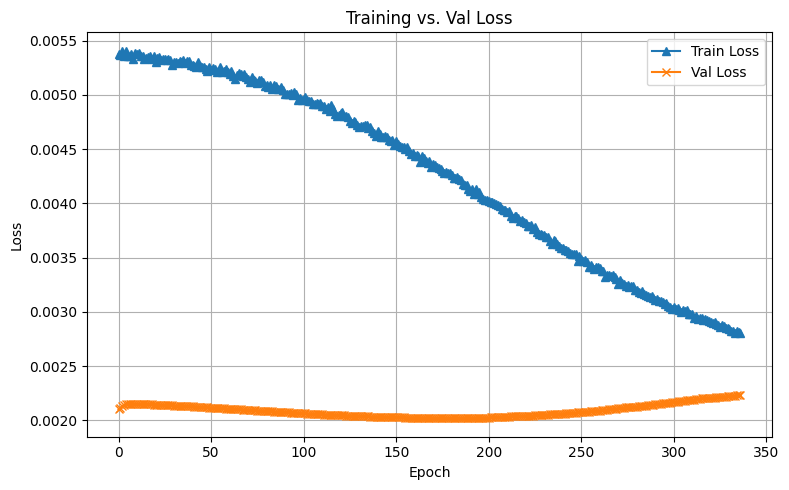

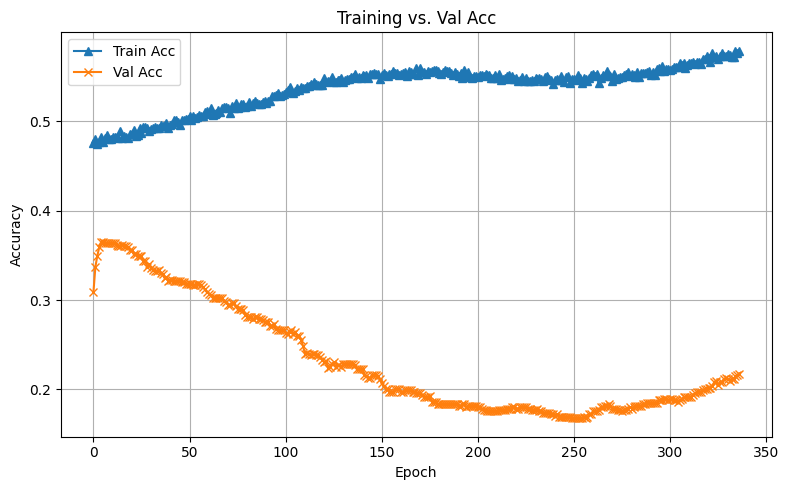

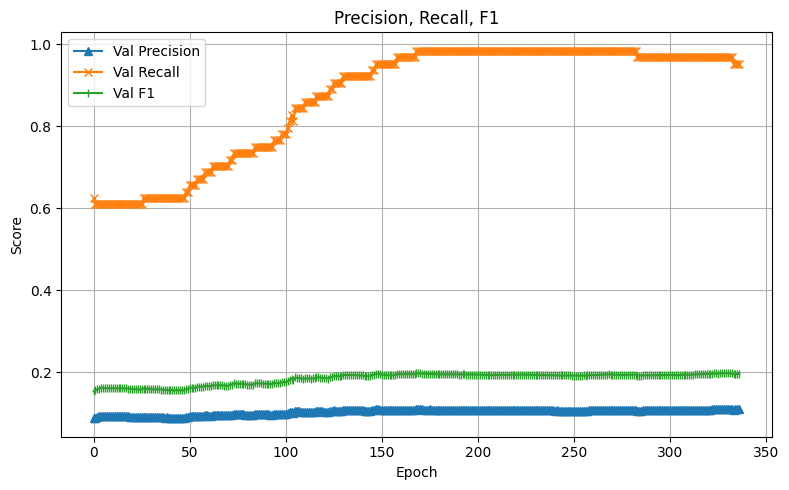

best loss_model saved to [loss_model.pkl]
best f1_model saved to [f1_model.pkl]
Training Statistics saved to [initialtraining.txt]


In [21]:
 
#? main model training and validation loop
trainingData = train_model(selectedModel, nInputs, train80_loader, val10_loader, epochs=epoch, learningRate=learningRate, threshold=threshold, patience=patience, path=directory)


#### Testing Loop Function

Loading best model State from epoch 330
Epoch [1/330]    Train Loss: 0.002864 Acc: 0.569000 | 
Epoch [2/330]    Train Loss: 0.002862 Acc: 0.567286 | 
Epoch [3/330]    Train Loss: 0.002859 Acc: 0.567571 | 
Epoch [4/330]    Train Loss: 0.002862 Acc: 0.568429 | 
Epoch [5/330]    Train Loss: 0.002859 Acc: 0.567429 | 
Epoch [6/330]    Train Loss: 0.002856 Acc: 0.569286 | 
Epoch [7/330]    Train Loss: 0.002855 Acc: 0.567571 | 
Epoch [8/330]    Train Loss: 0.002855 Acc: 0.566714 | 
Epoch [9/330]    Train Loss: 0.002854 Acc: 0.568571 | 
Epoch [10/330]   Train Loss: 0.002851 Acc: 0.567571 | 
Epoch [11/330]   Train Loss: 0.002850 Acc: 0.567429 | 
Epoch [12/330]   Train Loss: 0.002845 Acc: 0.567714 | 
Epoch [13/330]   Train Loss: 0.002844 Acc: 0.567286 | 
Epoch [14/330]   Train Loss: 0.002842 Acc: 0.568143 | 
Epoch [15/330]   Train Loss: 0.002843 Acc: 0.567714 | 
Epoch [16/330]   Train Loss: 0.002841 Acc: 0.568571 | 
Epoch [17/330]   Train Loss: 0.002836 Acc: 0.567000 | 
Epoch [18/330]   Train Lo

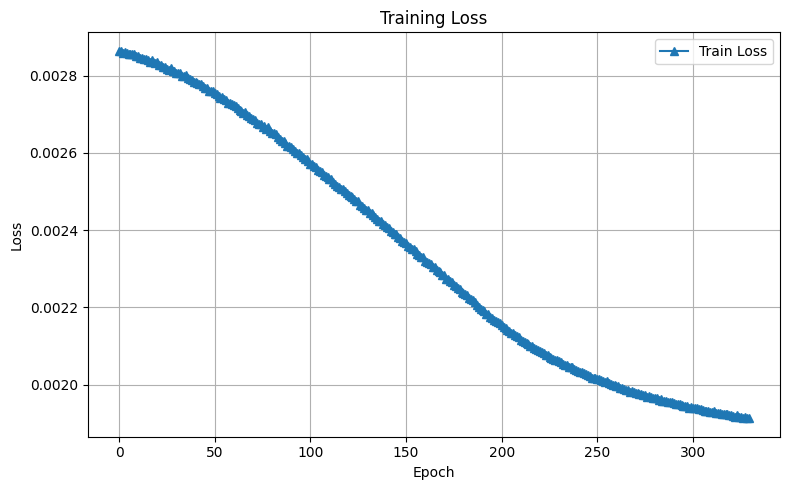

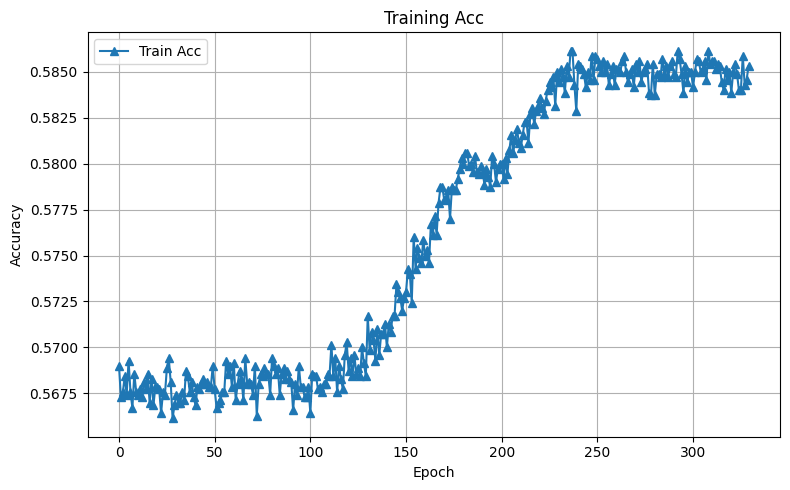

=======  Test Results  =======
|      Loss: 1.952830        |
|      Accuracy: 0.23%       |
|      Precision: 0.11       |
|      Recall: 0.89          |
|      F1 Score: 0.19        |
|      AUC Score: 0.52       |
final Model State Dict saved to [finalModel_Weights.pkl]
Test Statistics saved to [finalModel_Stats.txt]


In [22]:

#? model training and test loop
best_loss_model:dict = pickle.load(open(f"{directory}/f1_model.pkl", "rb"))
testingData = train_full_model(selectedModel, nInputs, best_loss_model, training90_loader, test10_loader,learningRate=learningRate, threshold=threshold, path=directory)
